**CNN_1:** implementation on original leaf images

size change of images

In [ ]:
# https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# baseline model with dropout and data augmentation on the cifar10 dataset

# Note: colab has changed the tensorflow version from 27 March 2020
# %tensorflow_version 1.x

import sys
import os
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.layers import BatchNormalization
import glob
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

EPOCSH = 2000
img_size = 128

pathModelSave = "/content/drive/My Drive/SavedModels/model_cnn_6_ori_imgsize_"+str(img_size)+"_.hdf5"
pathToSaveCSV_ori = "/content/drive/My Drive/SavedModels/CSV_6_imgSize_"+str(img_size)+"_ori.csv"

pathModelSave_seg = "/content/drive/My Drive/SavedModels/model_cnn_6_seg_img_"+str(img_size)+"_.hdf5"
pathToSaveCSV_seg = "/content/drive/My Drive/SavedModels/CSV_6_imgSize_seg_"+str(img_size)+"_.csv"

Using TensorFlow backend.


In [ ]:
# load train and test dataset

def prepare_data(path, img_size):

    X = []
    Y = []
    filenames = [img for img in glob.glob(path)]

    count = 0
    for i in tqdm(filenames):
      count = count + 1
      split = i.split(os.sep)[-3]
      if split != "alien_test":
        img = cv2.imread(i)
        img = cv2.resize(img, dsize=(img_size, img_size))
        X.append(img)
        split2 = i.split(os.sep)[-2]
        if split2 == "Healthy":
          Y.append(0)
        elif split2 == "Mild":
          Y.append(1)
        elif split2 == "Severe":
          Y.append(2)
    print('\n\n total images are:', count)

    # hot encoding
    # Y = to_categorical(Y)
    X = np.asarray(X)
    
    return X, Y

In [ ]:
X_ori, Y_ori = prepare_data('/content/drive/My Drive/datasets/vigna_mungo_leaves/*/*/*', img_size)

100%|██████████| 201/201 [02:49<00:00,  1.18it/s]



 total images are: 201


In [ ]:
# scale pixels
def prep_pixels(trainX, testX):
	# convert from integers to floats
	train_norm = trainX.astype('float32')
	test_norm = testX.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [ ]:
#@title Default title text
# define cnn model
def define_model():
	kernel = (3, 3)
	first_conv  = 32
	second_conv = first_conv * 2
	third_conv  = second_conv * 2

	model = Sequential()
	model.add(Conv2D(first_conv, kernel, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(img_size, img_size, 3)))
	model.add(BatchNormalization())
	
	model.add(Conv2D(first_conv, kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	
	model.add(Dropout(0.2))
	model.add(Conv2D(second_conv, kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	
	model.add(Conv2D(second_conv, kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	
	model.add(Dropout(0.3))
	model.add(Conv2D(third_conv, kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	
	model.add(Conv2D(third_conv, kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	
	model.add(Dropout(0.4))
	model.add(Flatten())
 
	model.add(Dense(third_conv, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
 
	model.add(Dropout(0.5))
	model.add(Dense(3, activation='softmax'))
 
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	model.summary()
	return model

# define model
model = define_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)       

In [ ]:
# load dataset
trainX, testX_, trainY, testY_ = train_test_split(X_ori, Y_ori, test_size=0.2, random_state = 0)
trainX, testX = prep_pixels(trainX, testX_)

# hot encoding
trainY = to_categorical(trainY)
testY = to_categorical(testY_)

datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
it_train = datagen.flow(trainX, trainY, batch_size = 8)

In [ ]:
%%time
# fit model
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(pathModelSave, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
csv_logger_ori = CSVLogger(pathToSaveCSV_ori, append=False, separator=',')

steps = int(trainX.shape[0] / 32)
history_ori = model.fit_generator(
    it_train, 
    steps_per_epoch = steps, 
    epochs=EPOCSH, 
    callbacks = [checkpoint, csv_logger_ori], 
    validation_data = (testX, testY), 
    verbose=1)

Epoch 1/2000
5/5 [==============================] - 3s 504ms/step - loss: 1.5459 - accuracy: 0.4500 - val_loss: 5.6436 - val_accuracy: 0.3171
Epoch 2/2000


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


5/5 [==============================] - 1s 228ms/step - loss: 1.3882 - accuracy: 0.4750 - val_loss: 3.6817 - val_accuracy: 0.3171
Epoch 3/2000
5/5 [==============================] - 1s 228ms/step - loss: 1.4016 - accuracy: 0.5000 - val_loss: 2.6155 - val_accuracy: 0.3171
Epoch 4/2000
5/5 [==============================] - 1s 231ms/step - loss: 0.8974 - accuracy: 0.5500 - val_loss: 3.0874 - val_accuracy: 0.3171
Epoch 5/2000
5/5 [==============================] - 1s 227ms/step - loss: 1.1544 - accuracy: 0.4750 - val_loss: 3.6203 - val_accuracy: 0.3171
Epoch 6/2000
5/5 [==============================] - 1s 229ms/step - loss: 1.0276 - accuracy: 0.4750 - val_loss: 4.8446 - val_accuracy: 0.3171
Epoch 7/2000
5/5 [==============================] - 1s 227ms/step - loss: 1.3011 - accuracy: 0.5500 - val_loss: 6.2800 - val_accuracy: 0.3171
Epoch 8/2000
5/5 [==============================] - 1s 231ms/step - loss: 0.6253 - accuracy: 0.6750 - val_loss: 4.8337 - val_accuracy: 0.3171
Epoch 9/2000
5/5 [=

In [ ]:
# evaluate model
_ori, acc_ori = model.evaluate(testX, testY, verbose=0)
print('acc is> %.3f' % (acc_ori * 100.0))

acc is> 100.000


In [ ]:
ori_model = load_model(pathModelSave)
_ori, acc_ori = ori_model.evaluate(testX, testY, verbose=0)
print('acc is> %.3f' % (acc_ori * 100.0))

acc is> 100.000


In [ ]:
model = load_model(pathModelSave)

(128, 128, 3)


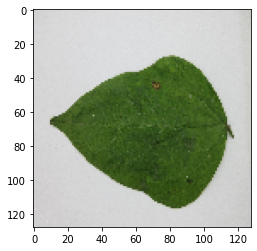

In [ ]:
# 
path_healthy = '/content/drive/My Drive/datasets/vigna_mungo_leaves/train/Mild/7.jpg'
img_vis = cv2.imread(path_healthy)
img_vis = cv2.resize(img_vis, dsize=(img_size, img_size))
img_vis = cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB)
# plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
plt.imshow(img_vis)
print(img_vis.shape)

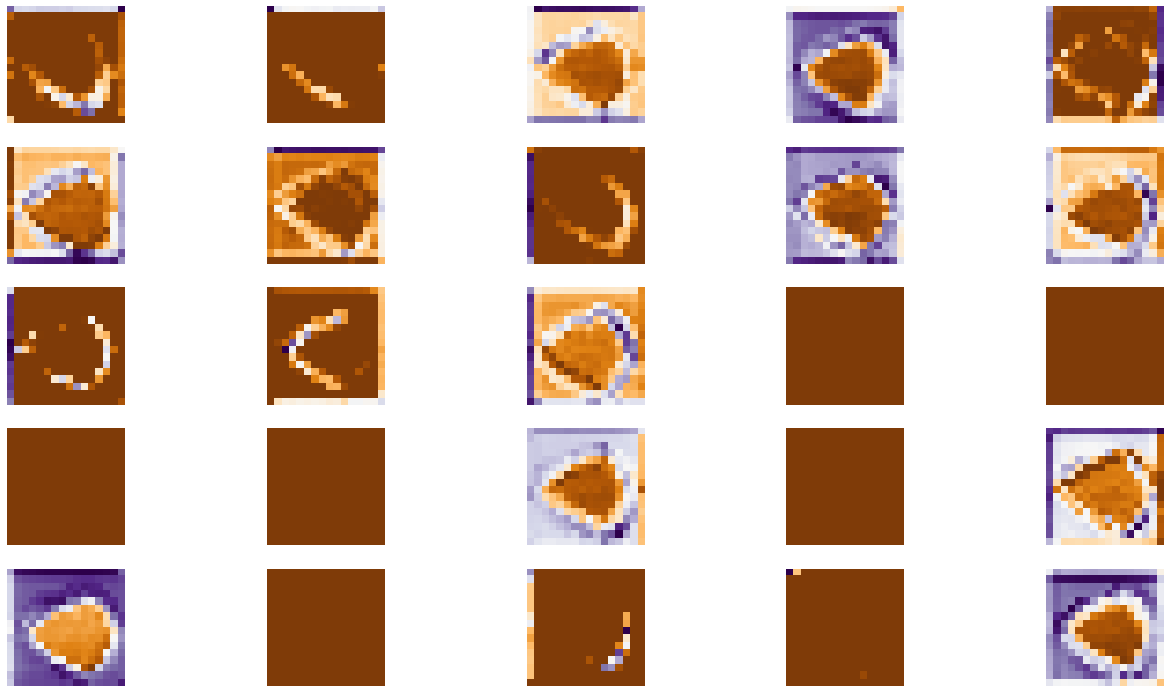

In [ ]:
# It is for intermediate conv2d layers visualization
from keras.models import Model

layer_outputs = [layer.output for layer in model.layers]
# print(layer_outputs)
activation_model = Model(inputs = model.input, outputs=layer_outputs)
# print(activation_model)
activations = activation_model.predict(img_vis.reshape(1,128,128,3))
# print(activations[22].shape)

# sys.exit()
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index = 0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*4.5, col_size*2.5)) # sharex=True, sharey=True
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0][:, :, activation_index], cmap='PuOr')
            ax[row,col].axis('off')
            activation_index += 1

display_activation(activations, 5, 5, 17)

Confusion matrix, without normalization


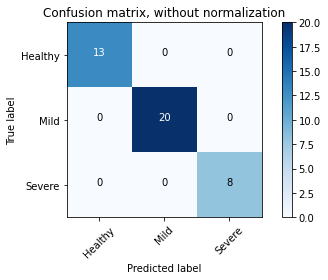

In [ ]:
# confusion matrix drawing for multiclass classification 
# https://github.com/javaidnabi31/Multi-class-with-imbalanced-dataset-classification/blob/master/20-news-group-classification.ipynb

def convert_string_label(intLabel):
  Y = []
  # print(intLabel)
  length = len(intLabel)
  for i in range(length):
    if intLabel[i] == 0:
      Y.append("Healthy")
    elif intLabel[i] == 1:
      Y.append("Mild")
    elif intLabel[i] == 2:
      Y.append("Severe")
  return Y
  
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


model = load_model(pathModelSave)

y_pred = model.predict(testX)
y_pred = np.rint(y_pred.argmax(axis=1))
y_pred = y_pred.tolist()

testY_ = np.rint(testY_)
testY_ = testY_.tolist()

y_true = convert_string_label(testY_)
y_predicted = convert_string_label(y_pred)

cnf_matrix = confusion_matrix(y_true, y_predicted, labels=['Healthy', 'Mild', 'Severe'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Healthy', 'Mild', 'Severe'], title='Confusion matrix, without normalization')

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	
  # plot loss
  plt.subplot(211)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='test')
  plt.show()

  # plot accuracy
  plt.subplot(212)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='test')
  plt.show()
  
  # save plot to file
  # filename = sys.argv[0].split('/')[-1]
  # pyplot.savefig(filename + '_plot.png')
  # pyplot.close()

  plt.plot(history.history["accuracy"])
  plt.plot(history.history['val_accuracy'])
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title("model accuracy")

  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.legend(["Training Accuracy","Validation Accuracy","Training loss","Validation Loss"])
  plt.show()

  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
  plt.show()


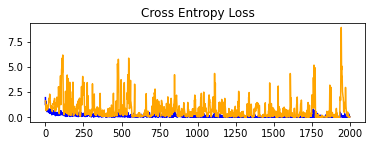

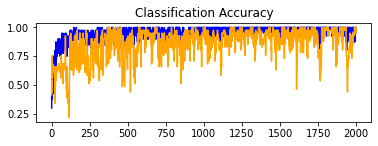

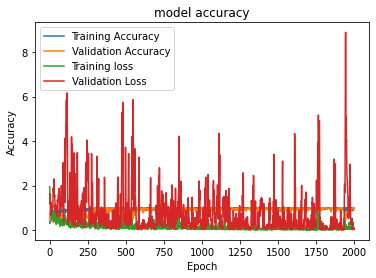

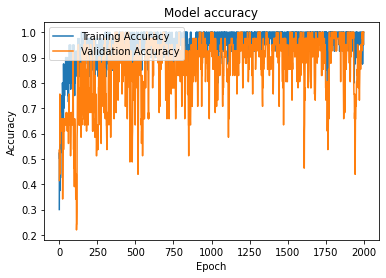

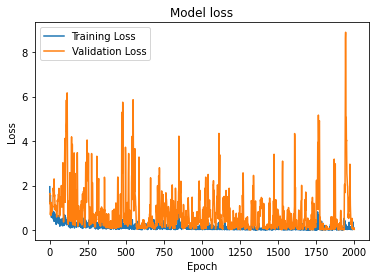

In [ ]:
# learning curves
summarize_diagnostics(history_ori)

In [ ]:
# alien data preparation for prediction
from tqdm import tqdm
import matplotlib.image as mpimg

def predict_imgs(path, type, modelPath): # 'type' is type of imgae like healthy, mild or severe
  tic = time.clock()
  model = load_model(modelPath)

  T = []
  names = []
  filenames = [img for img in glob.glob(path + '*')]

  count = 0
  for i in tqdm(filenames):
    split = i.split(os.sep)
    count = count + 1
    img = cv2.imread(i)
    img = cv2.resize(img, dsize=(img_size, img_size))
    img = img.astype('float32')
    img = img / 255.0
    T.append(img)
    names.append(split[-1])

  T = np.asarray(T)  
  p = model.predict(T)
  
  toc = time.clock()
  print("time to predict" + str(np.asarray(filenames).shape) + "images is:", toc-tic)

  probability = p
  count = 0
  healthy = 0
  mild = 0
  severe = 0

  for i in names:
    img = mpimg.imread(path+i)
    # plt.imshow(img) # to avovid DATA Loading
    if probability[count][0] > probability[count][1] and probability[count][0] > probability[count][2]:
      healthy = healthy + 1
      print("%.2f" % (probability[count][0]*100) + "% Healthy")
      # plt.title("%.2f" % (probability[count][0]*100) + "% Healthy")
    elif probability[count][1] > probability[count][0] and probability[count][1] > probability[count][2]:
      mild = mild + 1
      print("%.2f" % (probability[count][1]*100) + "% Mild")
      # plt.title("%.2f" % (probability[count][1]*100) + "% Mild")
    else:
      severe = severe + 1
      print("%.2f" % (probability[count][2]*100) + "% Severe")
      # plt.title("%.2f" % (probability[count][2]*100) + "% Severe")
    count = count + 1
    # plt.show()

  print("total " + type + " images:", count)
  print("Pridicted Healthy:", healthy)
  print("Pridicted Mild:", mild)
  print("Pridicted Severe:", severe)

In [ ]:
# this is the new prediction function <optimized> to calcultae prediction time per image
model = load_model(pathModelSave)

def new_prediction_fun(path):
  filenames = [img for img in glob.glob(path + '/*')]
  count = 0
  total_time = 0
  h = 0
  m = 0
  s = 0 
  for i in filenames:
      count += 1
      tic = time.clock()
      img = cv2.imread(i)
      img = cv2.resize(img, dsize=(img_size, img_size))
      img = img.astype('float32')
      img = img / 255.0
      img = img[np.newaxis, :]
      p = model.predict(img)[0]
      max_val_index = p.argmax()
      toc = time.clock()
      time_t = toc-tic
      if (max_val_index == 0):
        # print("%.2f" % (p[max_val_index]*100) + "% Healthy and prediction time is: ", time_t, " sec")
        h += 1
      elif (max_val_index == 1):
        # print("%.2f" % (p[max_val_index]*100) + "% mild and prediction time is: ", time_t, " sec")
        m += 1
      elif (max_val_index == 2):
        # print("%.2f" % (p[max_val_index]*100) + "% severe and prediction time is: ", time_t, " sec")
        s += 1
      total_time += time_t
  print("\n")    
  print("Total prediction time for "+str(count)+" images is: ", total_time, "sec")
  print("Average prediction time is:", total_time/count, "sec")
  print("Healthy predictions out of total "+str(count)+" "+str(os.path.split(path)[1])+" images are: ",h)
  print("Mild predictions out of total "+str(count)+" "+str(os.path.split(path)[1])+" images are: ",m)
  print("Severe predictions out of total "+str(count)+" "+str(os.path.split(path)[1])+" images are: ",s)  

In [ ]:
# new predction function on already resized 13 different images
# new_prediction_fun('/content/drive/My Drive/datasets/alien_test_leaves_ori/already_resized/different_32x32')
# new_prediction_fun('/content/drive/My Drive/datasets/alien_test_leaves_ori/already_resized/different_64x64')
new_prediction_fun('/content/drive/My Drive/datasets/alien_test_leaves_ori/already_resized/different_128x128')



Total prediction time for 13 images is:  1.2613269999999979 sec
Average prediction time is: 0.09702515384615368 sec
Healthy predictions out of total 13 different_128x128 images are:  9
Mild predictions out of total 13 different_128x128 images are:  4
Severe predictions out of total 13 different_128x128 images are:  0


In [ ]:
new_prediction_fun('/content/drive/My Drive/datasets/alien_test_leaves_ori/healthy')
new_prediction_fun('/content/drive/My Drive/datasets/alien_test_leaves_ori/mild')
new_prediction_fun('/content/drive/My Drive/datasets/alien_test_leaves_ori/severe')
new_prediction_fun('/content/drive/My Drive/datasets/alien_test_leaves_ori/different')



Total prediction time for 96 images is:  32.122791 sec
Average prediction time is: 0.33461240625 sec
Healthy predictions out of total 96 healthy images are:  86
Mild predictions out of total 96 healthy images are:  9
Severe predictions out of total 96 healthy images are:  1


Total prediction time for 229 images is:  74.70858899999995 sec
Average prediction time is: 0.3262383799126635 sec
Healthy predictions out of total 229 mild images are:  0
Mild predictions out of total 229 mild images are:  224
Severe predictions out of total 229 mild images are:  5


Total prediction time for 108 images is:  35.27363400000003 sec
Average prediction time is: 0.3266077222222225 sec
Healthy predictions out of total 108 severe images are:  0
Mild predictions out of total 108 severe images are:  13
Severe predictions out of total 108 severe images are:  95


Total prediction time for 13 images is:  1.1084089999999946 sec
Average prediction time is: 0.08526223076923035 sec
Healthy predictions out of 

In [ ]:
# single image testing for time to pridict


predict_imgs('/content/drive/My Drive/datasets/alien_test_leaves_ori/single_img_test_for_time_to_predict/healthy/', 'single_image', pathModelSave)
print("*********************")
predict_imgs('/content/drive/My Drive/datasets/alien_test_leaves_ori/single_img_test_for_time_to_predict/mild/', 'single_image', pathModelSave)
print("*********************")
predict_imgs('/content/drive/My Drive/datasets/alien_test_leaves_ori/single_img_test_for_time_to_predict/severe/', 'single_image', pathModelSave)
print("*********************")
predict_imgs('/content/drive/My Drive/datasets/alien_test_leaves_ori/single_img_test_for_time_to_predict/diff/', 'single_image', pathModelSave)

100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


time to predict(1,)images is: 3.3308600000000013
65.45% Healthy
total single_image images: 1
Pridicted Healthy: 1
Pridicted Mild: 0
Pridicted Severe: 0
*********************


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


time to predict(1,)images is: 3.6672480000000007
98.04% Mild
total single_image images: 1
Pridicted Healthy: 0
Pridicted Mild: 1
Pridicted Severe: 0
*********************


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


time to predict(1,)images is: 3.2954360000000236
98.72% Severe
total single_image images: 1
Pridicted Healthy: 0
Pridicted Mild: 0
Pridicted Severe: 1
*********************


100%|██████████| 1/1 [00:00<00:00, 25.45it/s]


time to predict(1,)images is: 3.163517000000013
100.00% Healthy
total single_image images: 1
Pridicted Healthy: 1
Pridicted Mild: 0
Pridicted Severe: 0


In [ ]:
predict_imgs('/content/drive/My Drive/datasets/alien_test_leaves_ori/healthy/', 'healthy', pathModelSave)

100%|██████████| 96/96 [01:15<00:00,  1.28it/s]


time to predict(96,)images is: 12.929141000000001
65.45% Healthy
58.33% Healthy
82.65% Healthy
62.63% Healthy
94.14% Healthy
76.94% Healthy
90.31% Healthy
77.54% Healthy
92.48% Healthy
87.67% Healthy
94.33% Healthy
60.86% Healthy
60.17% Healthy
57.75% Mild
47.85% Healthy
50.07% Healthy
59.96% Mild
56.71% Healthy
84.81% Healthy
59.62% Healthy
80.13% Mild
50.91% Healthy
47.16% Healthy
68.62% Healthy
90.07% Healthy
83.66% Healthy
79.48% Healthy
86.61% Healthy
61.59% Healthy
69.07% Healthy
81.09% Healthy
89.68% Healthy
87.97% Healthy
73.03% Healthy
86.77% Healthy
61.37% Healthy
78.46% Healthy
62.21% Healthy
70.47% Healthy
54.21% Healthy
96.66% Healthy
84.54% Healthy
96.82% Healthy
85.13% Healthy
72.37% Healthy
50.97% Healthy
83.44% Healthy
52.69% Mild
74.11% Healthy
48.74% Healthy
97.18% Healthy
89.39% Healthy
93.76% Healthy
78.27% Healthy
97.67% Healthy
94.17% Healthy
76.73% Healthy
43.50% Healthy
49.49% Healthy
60.45% Healthy
92.78% Healthy
86.22% Healthy
90.79% Healthy
81.62% Healthy
95

In [ ]:
predict_imgs('/content/drive/My Drive/datasets/alien_test_leaves_ori/mild/', 'mild', pathModelSave)

100%|██████████| 229/229 [03:03<00:00,  1.25it/s]


time to predict(229,)images is: 22.098448999999988
98.04% Mild
97.69% Mild
98.18% Mild
96.40% Mild
99.09% Mild
96.77% Mild
98.69% Mild
94.91% Mild
99.57% Mild
99.29% Mild
98.33% Mild
99.56% Mild
99.86% Mild
99.26% Mild
98.58% Mild
95.84% Mild
98.59% Mild
95.88% Mild
98.74% Mild
98.12% Mild
99.63% Mild
97.92% Mild
97.96% Mild
98.20% Mild
98.52% Mild
100.00% Mild
97.89% Mild
98.04% Mild
97.83% Mild
98.09% Mild
97.88% Mild
95.24% Mild
75.06% Mild
84.14% Mild
52.91% Mild
73.34% Mild
53.55% Mild
85.31% Mild
97.63% Mild
99.17% Mild
99.78% Mild
97.88% Mild
98.02% Mild
95.02% Mild
94.60% Mild
94.02% Mild
98.27% Mild
93.04% Mild
97.75% Mild
95.92% Mild
99.00% Mild
98.65% Mild
93.86% Mild
98.18% Mild
99.69% Mild
99.65% Mild
91.39% Mild
94.21% Mild
94.03% Mild
94.62% Mild
98.69% Mild
99.14% Mild
98.15% Mild
93.47% Mild
90.75% Mild
91.30% Mild
99.53% Mild
86.67% Mild
99.17% Mild
98.53% Mild
99.98% Mild
97.10% Mild
99.22% Mild
98.26% Mild
99.48% Mild
97.60% Mild
99.98% Mild
96.74% Mild
99.99% Mild


In [ ]:
predict_imgs('/content/drive/My Drive/datasets/alien_test_leaves_ori/severe/', 'severe', pathModelSave)

100%|██████████| 108/108 [01:13<00:00,  1.48it/s]


time to predict(108,)images is: 9.885964000000001
98.72% Severe
94.09% Severe
99.26% Severe
98.55% Severe
99.66% Severe
96.58% Severe
52.96% Mild
66.67% Severe
94.79% Severe
87.47% Severe
96.17% Severe
98.84% Severe
93.72% Severe
96.35% Severe
90.18% Severe
98.78% Severe
98.16% Severe
99.60% Severe
98.72% Severe
98.66% Severe
96.65% Severe
90.82% Severe
98.24% Severe
94.19% Severe
52.74% Mild
52.89% Mild
60.22% Mild
90.58% Mild
75.93% Severe
61.91% Severe
93.07% Severe
71.53% Severe
90.58% Severe
59.75% Severe
74.72% Severe
52.94% Severe
76.50% Severe
72.09% Mild
99.71% Severe
99.06% Severe
81.59% Severe
62.29% Severe
95.13% Severe
92.94% Severe
81.98% Severe
99.19% Severe
72.31% Severe
57.90% Mild
90.37% Severe
86.12% Severe
76.66% Severe
93.32% Severe
98.81% Severe
96.11% Severe
99.42% Severe
97.48% Severe
99.41% Severe
96.85% Severe
99.13% Severe
96.85% Severe
99.37% Severe
97.92% Severe
98.99% Severe
97.72% Severe
95.24% Severe
99.97% Severe
96.63% Severe
92.03% Severe
98.77% Sever

In [ ]:
%%time
predict_imgs('/content/drive/My Drive/datasets/alien_test_leaves_ori/different/', 'different', pathModelSave)

100%|██████████| 13/13 [00:03<00:00,  3.57it/s]


time to predict(13,)images is: 2.1547379999999947
99.97% Mild
99.28% Mild
99.50% Mild
100.00% Healthy
99.84% Mild
100.00% Healthy
99.97% Healthy
100.00% Healthy
100.00% Healthy
100.00% Healthy
99.59% Healthy
100.00% Healthy
100.00% Healthy
total different images: 13
Pridicted Healthy: 9
Pridicted Mild: 4
Pridicted Severe: 0
CPU times: user 4.37 s, sys: 673 ms, total: 5.04 s
Wall time: 7.18 s


In [ ]:
print(type(history_ori))
...
# list all data in history
print(history_ori.history.keys())

<class 'keras.callbacks.History'>
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [ ]:
print(history_ori.history['loss'])

[1.6147231479606978, 1.638691039574219, 1.1768211504308188, 1.222878444485548, 0.6862581706628567, 0.7577413974738703, 0.8293126210933779, 0.6553598206217696, 0.9123166770469852, 1.2399330139160156, 1.1069551502786033, 0.9066931736178514, 0.8899625278100735, 0.8668171196449094, 0.8336983308559511, 0.80722436090795, 0.8750437701620707, 1.02267611899027, 1.0757231188983452, 1.0458749038417166, 1.0272093865929581, 1.5775422061361917, 1.8811370919390422, 1.8215750601233505, 1.7706577952315168, 1.705599877892471, 1.670259045391548, 1.837127173819193, 2.297400497808689, 2.2415619129087867, 1.5030158903540634, 1.566637306678586, 1.5825008531896079, 1.256303252243414, 1.166381010195104, 0.9020444590870927, 1.0108669909035288, 1.1365164431130015, 1.0660212912210605, 0.9423243534274217, 0.8777701505800573, 1.0720796933988246, 0.9314502041514326, 0.8425584188321742, 0.7651184535608059, 0.5809717381872782, 0.6715523324361662, 0.8672836640986, 0.9982242177172405, 0.8429510011905577, 1.3315966885264

In [ ]:
print(history_ori.history['val_loss'])

[1.6147231479606978, 1.638691039574219, 1.1768211504308188, 1.222878444485548, 0.6862581706628567, 0.7577413974738703, 0.8293126210933779, 0.6553598206217696, 0.9123166770469852, 1.2399330139160156, 1.1069551502786033, 0.9066931736178514, 0.8899625278100735, 0.8668171196449094, 0.8336983308559511, 0.80722436090795, 0.8750437701620707, 1.02267611899027, 1.0757231188983452, 1.0458749038417166, 1.0272093865929581, 1.5775422061361917, 1.8811370919390422, 1.8215750601233505, 1.7706577952315168, 1.705599877892471, 1.670259045391548, 1.837127173819193, 2.297400497808689, 2.2415619129087867, 1.5030158903540634, 1.566637306678586, 1.5825008531896079, 1.256303252243414, 1.166381010195104, 0.9020444590870927, 1.0108669909035288, 1.1365164431130015, 1.0660212912210605, 0.9423243534274217, 0.8777701505800573, 1.0720796933988246, 0.9314502041514326, 0.8425584188321742, 0.7651184535608059, 0.5809717381872782, 0.6715523324361662, 0.8672836640986, 0.9982242177172405, 0.8429510011905577, 1.3315966885264

In [ ]:
print(history_ori.history['accuracy'])

[1.946699595451355, 1.2099444627761842, 1.5479833126068114, 1.4524463057518004, 1.5711600065231324, 1.1737653374671937, 1.19598987698555, 0.9857332468032837, 1.0154624938964845, 0.8693858504295349, 0.9027871727943421, 0.5639498233795166, 0.7342651784420013, 0.6883358538150788, 0.8946852028369904, 0.7550951600074768, 0.8813461244106293, 1.0280081629753113, 0.5583542943000793, 0.8001842617988586, 0.7221287369728089, 0.6247177362442017, 0.6913618385791779, 0.6470989406108856, 0.4815889477729797, 0.8266039490699768, 0.4851489007472992, 0.5452690482139587, 0.3905809998512268, 0.658229586482048, 0.5177216589450836, 0.7678817749023438, 0.5784137129783631, 0.6956564903259277, 0.6553878903388977, 0.5838504791259765, 0.3958095759153366, 0.45830739140510557, 0.5090103089809418, 0.5797443747520447, 0.3284350037574768, 0.4602947771549225, 0.25136353075504303, 0.5348820418119431, 0.3065753012895584, 0.41552906334400175, 0.5294168174266816, 0.31463918536901475, 0.3621480420231819, 0.635984480381012, 

In [ ]:
print(history_ori.history['val_accuracy'])

[0.3, 0.525, 0.5, 0.55, 0.375, 0.425, 0.625, 0.55, 0.425, 0.45, 0.6, 0.75, 0.65, 0.625, 0.625, 0.675, 0.675, 0.525, 0.725, 0.6, 0.7, 0.8, 0.775, 0.725, 0.75, 0.675, 0.725, 0.625, 0.875, 0.75, 0.7, 0.725, 0.75, 0.8, 0.75, 0.75, 0.85, 0.825, 0.775, 0.8, 0.875, 0.825, 0.9, 0.775, 0.875, 0.875, 0.8, 0.9, 0.825, 0.775, 0.85, 0.85, 0.9, 0.825, 0.825, 0.775, 0.75, 0.875, 0.8, 0.85, 0.725, 0.775, 0.875, 0.9, 0.85, 0.825, 0.95, 0.875, 0.8, 0.875, 0.9, 0.925, 0.925, 0.925, 0.95, 0.775, 0.9, 0.85, 0.925, 0.825, 0.875, 0.85, 0.9, 0.9, 0.925, 0.8, 0.9, 0.9, 0.825, 0.95, 0.925, 0.9, 0.775, 0.875, 0.825, 0.85, 0.95, 0.925, 0.875, 0.875, 0.775, 0.75, 0.825, 0.8, 0.925, 0.9, 0.825, 0.9, 0.9, 0.85, 0.925, 0.925, 0.925, 0.85, 0.875, 0.85, 0.875, 0.925, 0.875, 0.825, 0.875, 0.925, 0.975, 0.875, 0.975, 0.875, 0.825, 0.85, 0.9, 0.875, 0.85, 0.975, 0.95, 0.825, 0.925, 0.95, 0.925, 0.95, 0.925, 0.9, 0.875, 0.9, 0.9, 0.875, 0.9, 0.9, 1.0, 0.85, 0.85, 0.775, 0.9, 0.9, 0.85, 0.9, 0.975, 0.875, 0.95, 0.9, 0.825, 

**Predictions: When train and validate on total 24 images**<br> 
total Severe images: 96<br>
Pridicted Healthy: 95<br>
Pridicted Mild: 1<br>
Pridicted Severe: 0

**Predictions: When train and validate on total 24 images**<br> 
total Severe images: 108<br>
Pridicted Healthy: 0<br>
Pridicted Mild: 16<br>
Pridicted Severe: 92

**Predictions: When train and validate on total 24 images**<br> 
total Mild images: 229<br>
Pridicted Healthy: 26<br>
Pridicted Mild: 181<br>
Pridicted Severe: 22

**CNN_2:** implementation on segmented leaf images

In [ ]:
X_seg, Y_seg = prepare_data('/content/drive/My Drive/datasets/seg_leaves/*/*/*', img_size)

# load dataset
trainX_seg, testX_seg_, trainY_seg, testY_seg_ = train_test_split(X_seg, Y_seg, test_size=0.2, random_state = 0)
trainX_seg, testX_seg = prep_pixels(trainX_seg, testX_seg_)

# hot encoding
trainY_seg = to_categorical(trainY_seg)
testY_seg  = to_categorical(testY_seg_)

datagen_seg = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
it_train_seg = datagen_seg.flow(trainX_seg, trainY_seg, batch_size=8)

100%|██████████| 201/201 [00:53<00:00,  3.79it/s]



 total images are: 201


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_seg = ModelCheckpoint(pathModelSave_seg, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
csv_logger_seg = CSVLogger(pathToSaveCSV_seg, append=False, separator=',')

# define model
model = define_model()

# fit model
steps = int(trainX_seg.shape[0] / 32)
history_seg = model.fit_generator(
    it_train_seg,
    steps_per_epoch = steps,
    epochs= EPOCSH,
    callbacks = [checkpoint_seg, csv_logger_seg],
    validation_data = (testX_seg, testY_seg),
    verbose=1)

Streaming output truncated to the last 5000 lines.
5/5 [==============================] - 1s 256ms/step - loss: 0.0723 - acc: 0.9750 - val_loss: 0.3410 - val_acc: 0.8537

Epoch 00751: val_acc did not improve from 0.97561
Epoch 752/2000
5/5 [==============================] - 1s 258ms/step - loss: 0.1266 - acc: 0.9250 - val_loss: 0.2201 - val_acc: 0.9024

Epoch 00752: val_acc did not improve from 0.97561
Epoch 753/2000
5/5 [==============================] - 1s 251ms/step - loss: 0.0832 - acc: 0.9750 - val_loss: 0.2458 - val_acc: 0.9024

Epoch 00753: val_acc did not improve from 0.97561
Epoch 754/2000
5/5 [==============================] - 1s 251ms/step - loss: 0.1639 - acc: 0.9500 - val_loss: 0.4003 - val_acc: 0.8537

Epoch 00754: val_acc did not improve from 0.97561
Epoch 755/2000
5/5 [==============================] - 1s 248ms/step - loss: 0.1322 - acc: 0.9250 - val_loss: 0.7617 - val_acc: 0.7317

Epoch 00755: val_acc did not improve from 0.97561
Epoch 756/2000
5/5 [===================

In [ ]:
# evaluate model
_seg, acc_seg = model.evaluate(testX_seg, testY_seg, verbose=0)
print('acc is> %.3f' % (acc_seg * 100.0))

acc is> 75.610


In [ ]:
seg_model = load_model(pathModelSave_seg)
_seg, acc_seg = seg_model.evaluate(testX_seg, testY_seg, verbose=0)
print('acc is> %.3f' % (acc_seg * 100.0))

acc is> 97.561


Confusion matrix, without normalization


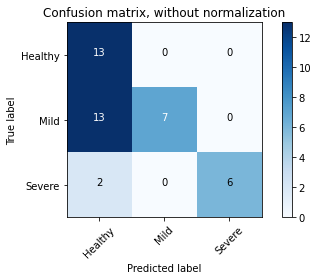

In [ ]:
# confusion matrix plotting
model = load_model(pathModelSave_seg)

y_pred = model.predict(testX)
y_pred = np.rint(y_pred.argmax(axis=1))
y_pred = y_pred.tolist()

testY_ = np.rint(testY_)
testY_ = testY_.tolist()

y_true = convert_string_label(testY_)
y_predicted = convert_string_label(y_pred)

cnf_matrix = confusion_matrix(y_true, y_predicted, labels=['Healthy', 'Mild', 'Severe'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Healthy', 'Mild', 'Severe'], title='Confusion matrix, without normalization')

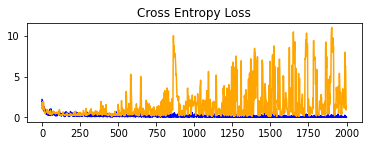

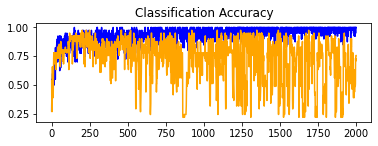

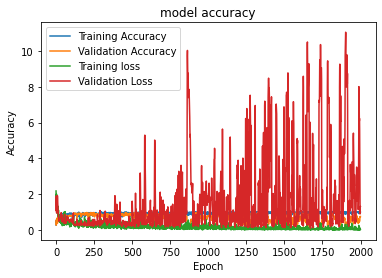

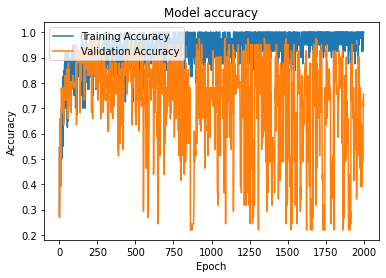

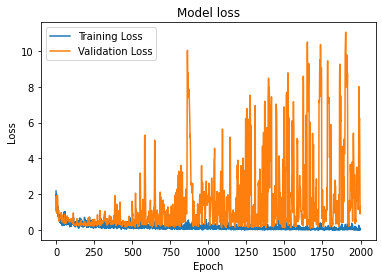

In [ ]:
# learning curves
summarize_diagnostics(history_seg)

In [ ]:
predict_imgs('/content/drive/My Drive/datasets/alien_test_leaves_seg/healthy/', 'healthy', pathModelSave_seg)

100%|██████████| 96/96 [00:18<00:00,  5.16it/s]


time to predict(96,)images is: 8.486170999999956
65.06% Healthy
61.90% Healthy
72.62% Healthy
70.12% Healthy
98.35% Healthy
95.63% Healthy
92.49% Healthy
94.38% Healthy
95.73% Healthy
93.95% Healthy
97.70% Healthy
95.28% Healthy
87.99% Healthy
94.18% Healthy
67.56% Healthy
84.41% Healthy
82.59% Healthy
91.35% Healthy
95.82% Healthy
92.82% Healthy
55.09% Healthy
89.83% Healthy
90.40% Healthy
95.14% Healthy
98.35% Healthy
96.99% Healthy
96.93% Healthy
97.60% Healthy
94.61% Healthy
94.16% Healthy
96.04% Healthy
97.70% Healthy
97.41% Healthy
95.35% Healthy
96.71% Healthy
95.21% Healthy
86.74% Healthy
94.21% Healthy
94.85% Healthy
94.97% Healthy
92.71% Healthy
93.58% Healthy
82.89% Healthy
81.32% Healthy
58.08% Healthy
67.09% Healthy
59.67% Healthy
61.90% Healthy
55.65% Healthy
55.70% Healthy
98.78% Healthy
97.28% Healthy
97.85% Healthy
96.91% Healthy
99.19% Healthy
98.76% Healthy
93.45% Healthy
93.74% Healthy
82.34% Healthy
90.26% Healthy
97.83% Healthy
95.84% Healthy
95.95% Healthy
96.43%

In [ ]:
predict_imgs('/content/drive/My Drive/datasets/alien_test_leaves_seg/mild/', 'mild', pathModelSave_seg)

100%|██████████| 229/229 [00:56<00:00,  4.06it/s]


time to predict(229,)images is: 20.61457200000001
89.19% Mild
85.29% Mild
79.26% Mild
68.30% Mild
88.11% Mild
69.01% Mild
82.72% Mild
70.16% Mild
94.53% Mild
99.52% Mild
96.04% Mild
89.92% Mild
93.65% Mild
93.08% Mild
81.52% Mild
59.29% Mild
95.43% Mild
88.97% Mild
87.73% Mild
80.21% Mild
94.01% Mild
96.97% Mild
65.96% Mild
82.01% Mild
78.96% Mild
71.63% Mild
88.25% Mild
84.92% Mild
91.82% Mild
86.93% Mild
89.66% Mild
81.03% Mild
54.60% Mild
51.04% Mild
56.31% Severe
49.36% Severe
60.46% Mild
49.28% Mild
70.93% Mild
66.95% Mild
79.58% Mild
70.05% Mild
89.54% Mild
90.64% Mild
79.00% Mild
69.68% Mild
80.67% Mild
79.90% Mild
97.09% Mild
86.60% Mild
74.65% Mild
70.52% Mild
77.46% Mild
74.82% Mild
84.91% Mild
84.90% Mild
73.41% Mild
79.80% Mild
87.01% Mild
81.51% Mild
87.37% Mild
83.37% Mild
92.30% Mild
85.76% Mild
87.59% Mild
81.46% Mild
92.26% Mild
86.88% Mild
96.02% Mild
91.11% Mild
92.95% Mild
88.42% Mild
96.29% Mild
92.82% Mild
96.86% Mild
78.82% Mild
97.12% Mild
90.88% Mild
96.50% Mil

In [ ]:
predict_imgs('/content/drive/My Drive/datasets/alien_test_leaves_seg/severe/', 'severe', pathModelSave_seg)

100%|██████████| 108/108 [00:20<00:00,  5.21it/s]


time to predict(108,)images is: 9.598357000000021
93.98% Severe
91.66% Severe
94.64% Severe
95.69% Severe
96.80% Severe
94.43% Severe
61.95% Severe
50.57% Mild
80.27% Severe
87.70% Severe
91.33% Severe
91.10% Severe
86.89% Severe
84.28% Severe
76.58% Severe
96.55% Severe
95.56% Severe
95.35% Severe
95.09% Severe
94.60% Severe
92.82% Severe
87.45% Severe
94.04% Severe
91.50% Severe
92.88% Mild
85.45% Mild
47.01% Mild
46.06% Mild
52.18% Severe
52.20% Severe
81.96% Severe
65.02% Severe
84.22% Severe
72.15% Severe
63.40% Severe
60.89% Severe
77.91% Severe
52.40% Severe
92.77% Severe
93.72% Severe
50.59% Mild
58.59% Severe
86.27% Severe
90.94% Severe
66.58% Severe
77.87% Severe
59.77% Mild
54.22% Mild
81.83% Severe
84.12% Severe
72.87% Severe
75.68% Severe
89.87% Severe
92.05% Severe
94.35% Severe
94.36% Severe
88.21% Severe
90.19% Severe
92.29% Severe
93.98% Severe
93.04% Severe
92.76% Severe
93.47% Severe
95.95% Severe
85.58% Severe
72.30% Severe
92.19% Severe
89.35% Severe
88.84% Severe


In [ ]:
predict_imgs('/content/drive/My Drive/datasets/alien_test_leaves_ori/different/', 'different', pathModelSave_seg)

100%|██████████| 13/13 [00:00<00:00, 90.86it/s] 


time to predict(13,)images is: 1.3690159999999878
98.67% Mild
98.09% Mild
97.80% Mild
99.27% Severe
52.34% Mild
99.99% Severe
99.65% Healthy
49.22% Mild
77.29% Healthy
100.00% Healthy
99.99% Healthy
99.19% Healthy
99.71% Healthy
total different images: 13
Pridicted Healthy: 6
Pridicted Mild: 5
Pridicted Severe: 2


**acc is> 92.683** with 64x64 image size and initial input size<br>
**acc is> 75.610** with 128x128 image size and initial input size: took total 48 minutes to train on 10 epoches